In [171]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau




In [172]:
import os
import pandas as pd

# Tentukan direktori dataset
cwd = os.getcwd()
used_dataset_dir = os.path.join(cwd, 'Used_Dataset')

# Membaca data dari file CSV
weather_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'weather_2022.csv'))
tidal_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'tidal_daily_average_22.csv'))

# Tampilkan 5 baris pertama untuk memeriksa data
print(weather_df_2022.head())
print(tidal_df_2022.head())


   Time (UTC)    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg
0  2022-01-01  24.4  30.8  28.3    81.0   6.1  7.6   4.0  280.0     3.0
1  2022-01-02  25.3  30.1  27.7    82.0   3.5  4.0   4.0  290.0     2.0
2  2022-01-03  24.1  30.1  27.8    81.0  16.7  2.4   5.0  290.0     3.0
3  2022-01-04  24.6  30.1  26.7    84.0   9.5  2.0   6.0  260.0     3.0
4  2022-01-05  24.5  28.8  26.7    80.0   6.7  2.2   6.0  260.0     2.0
         Date                     Time (UTC)    rad(m)
0  2022-01-01  2022-01-01 08:04:29.904357120  0.326968
1  2022-01-02  2022-01-02 06:24:43.846153984  0.270584
2  2022-01-03  2022-01-03 06:09:42.892906752  0.079565
3  2022-01-04  2022-01-04 06:11:20.400000000  0.001373
4  2022-01-05  2022-01-05 06:05:06.863084800 -0.024731


In [173]:
# Pastikan kolom 'Date' dalam format datetime
weather_df_2022.rename(columns={'Time (UTC)': 'Date'}, inplace=True)
tidal_df_2022.drop(columns=['Time (UTC)'], inplace=True)

weather_df_2022['Date'] = pd.to_datetime(weather_df_2022['Date'], errors='coerce')
tidal_df_2022['Date'] = pd.to_datetime(tidal_df_2022['Date'], errors='coerce')

# Gabungkan kedua dataset berdasarkan tanggal
merged_data = pd.merge(weather_df_2022, tidal_df_2022, on='Date', how='inner')
merged_data = merged_data.sort_values(by='Date')

# Hapus kolom 'Date' setelah penggabungan=
print(merged_data.head())


        Date    Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg  \
0 2022-01-01  24.4  30.8  28.3    81.0   6.1  7.6   4.0  280.0     3.0   
1 2022-01-02  25.3  30.1  27.7    82.0   3.5  4.0   4.0  290.0     2.0   
2 2022-01-03  24.1  30.1  27.8    81.0  16.7  2.4   5.0  290.0     3.0   
3 2022-01-04  24.6  30.1  26.7    84.0   9.5  2.0   6.0  260.0     3.0   
4 2022-01-05  24.5  28.8  26.7    80.0   6.7  2.2   6.0  260.0     2.0   

     rad(m)  
0  0.326968  
1  0.270584  
2  0.079565  
3  0.001373  
4 -0.024731  


In [174]:
def assign_condition(row):
    # Kondisi "Tidak Aman" - suhu sangat tinggi atau angin sangat kencang
    if row['Tx'] > 40 or row['ff_avg'] > 1.5:  # Suhu sangat tinggi atau angin sangat kencang
        return 'Tidak Aman'
    
    # Kondisi "Tidak Aman" - suhu sangat tinggi dan kelembapan sangat tinggi
    elif row['Tx'] > 38 and row['RH_avg'] > 85:  # Suhu sangat tinggi dan kelembapan sangat tinggi
        return 'Tidak Aman'
    
    # Kondisi "Tidak Aman" - suhu rendah dan radiasi tinggi
    elif row['Tn'] < 5 and row['rad(m)'] > 800:  # Suhu rendah dan radiasi sangat tinggi
        return 'Tidak Aman'
    
    # Kondisi "Risiko" - suhu tinggi dan kelembapan sangat tinggi
    elif row['Tavg'] > 32 and row['RH_avg'] > 75:  # Suhu tinggi dan kelembapan sangat tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu tinggi dan radiasi sangat tinggi
    elif row['Tavg'] > 32 and row['rad(m)'] > 700:  # Suhu tinggi dan radiasi sangat tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu moderat dan kelembapan tinggi
    elif 25 <= row['Tavg'] <= 30 and row['RH_avg'] > 65:  # Suhu sedang dan kelembapan tinggi
        return 'Risiko'
    
    # Kondisi "Risiko" - suhu sedang dan angin sedang
    elif 25 <= row['Tavg'] <= 30 and 0.5 < row['ff_avg'] <= 1.0:  # Suhu sedang tinggi dan angin sedang
        return 'Risiko'
    
    # Kondisi "Aman" - suhu rendah dengan kelembapan rendah
    elif row['Tn'] < 15 and row['RH_avg'] < 50:  # Suhu rendah dan kelembapan rendah
        return 'Aman'
    
    # Kondisi "Aman" - suhu moderat dan angin ringan
    elif 15 <= row['Tavg'] <= 25 and row['ff_avg'] < 0.3:  # Suhu moderat dan angin ringan
        return 'Aman'
    
    # Kondisi "Aman" - suhu sedang dan kelembapan sedang
    elif 20 <= row['Tavg'] <= 28 and 40 <= row['RH_avg'] <= 60:  # Suhu sedang dan kelembapan sedang
        return 'Aman'
    
    # Jika tidak ada kondisi lain yang memenuhi, anggap kondisi sebagai "Aman"
    return 'Aman'

# Terapkan fungsi untuk menentukan kondisi
merged_data['Condition'] = merged_data.apply(assign_condition, axis=1)


In [175]:
# Mengubah label menjadi kategori numerik (Aman: 0, Risiko: 1, Tidak Aman: 2)
condition_mapping = {'Aman': 0, 'Risiko': 1, 'Tidak Aman': 2}
print(condition_mapping)
# Hapus spasi ekstra di awal dan akhir string jika ada
merged_data['Condition'] = merged_data['Condition'].str.strip()
# Mencoba pemetaan ulang
merged_data['Condition'] = merged_data['Condition'].map(condition_mapping)

# Periksa hasilnya
print(merged_data[['Date', 'Condition']].head())

{'Aman': 0, 'Risiko': 1, 'Tidak Aman': 2}
        Date  Condition
0 2022-01-01          2
1 2022-01-02          2
2 2022-01-03          2
3 2022-01-04          2
4 2022-01-05          2


In [176]:
# Hitung jumlah masing-masing label dalam kolom 'Condition'
condition_counts = merged_data['Condition'].value_counts()

# Mencetak jumlah tiap label dengan deskripsi yang lebih jelas
for label, count in condition_counts.items():
    # Menampilkan label deskriptif berdasarkan pemetaan
    condition_name = [key for key, value in condition_mapping.items() if value == label][0]
    print(f"{condition_name}: {count}")


Tidak Aman: 342
Aman: 15
Risiko: 8


In [177]:

# Pilih fitur numerik yang akan digunakan untuk normalisasi
numerical_features = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']

# Normalisasi data
scaler = MinMaxScaler()
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Periksa data setelah normalisasi
print(merged_data.head())


        Date        Tn        Tx      Tavg    RH_avg    RR   ss  ff_x  ddd_x  \
0 2022-01-01  0.406250  0.578947  0.336905  0.835052   6.1  7.6   4.0  280.0   
1 2022-01-02  0.546875  0.456140  0.329762  0.845361   3.5  4.0   4.0  290.0   
2 2022-01-03  0.359375  0.456140  0.330952  0.835052  16.7  2.4   5.0  290.0   
3 2022-01-04  0.437500  0.456140  0.317857  0.865979   9.5  2.0   6.0  260.0   
4 2022-01-05  0.421875  0.228070  0.317857  0.824742   6.7  2.2   6.0  260.0   

     ff_avg    rad(m)  Condition  
0  0.222222  1.000000          2  
1  0.111111  0.951195          2  
2  0.222222  0.785853          2  
3  0.222222  0.718172          2  
4  0.111111  0.695576          2  


In [178]:
merged_data = merged_data.dropna(subset=numerical_features + ['Condition'])


In [179]:
sequence_length = 1
data_sequences = []

for i in range(len(merged_data) - sequence_length):
    sequence = merged_data[numerical_features].iloc[i:i + sequence_length].values
    data_sequences.append(sequence)

# Convert ke numpy array
X = np.array(data_sequences)

# Sesuaikan panjang y
y = merged_data['Condition'].iloc[sequence_length:].values  # Sesuaikan panjang y dengan X

# Verifikasi bentuk data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (347, 1, 6)
Shape of y: (347,)


In [180]:
# Coba modifikasi model dan hiperparameter
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True,
                    input_shape=(sequence_length, len(numerical_features)),
                    kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
lstm_model.add(Dropout(0.5))  # Menambah dropout
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(32, return_sequences=False,
                    kernel_regularizer=L1L2(l1=1e-5, l2=1e-4)))
lstm_model.add(Dropout(0.5))  # Menambah dropout
lstm_model.add(Dense(3, activation='softmax'))  # Output layer dengan 3 kelas (Aman, Risiko, Tidak Aman)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [181]:
# Callback untuk pengurangan learning rate dan early stopping
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [182]:
from sklearn.utils import class_weight

# Menentukan bobot kelas berdasarkan distribusi
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# Pelatihan dengan class weights
history = lstm_model.fit(
    X, y,
    epochs=30,
    batch_size=16,
    verbose=1,
    validation_split=0.2,
    class_weight=class_weight_dict,  # Menambahkan class weights
    callbacks=[reduce_lr, early_stopping]
)
# Simpan model jika diperlukan
lstm_model.save('lstm_classification_model.h5')
print("Model LSTM untuk klasifikasi telah disimpan.")



Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3338 - loss: 1.1088 - val_accuracy: 1.0000 - val_loss: 1.0514 - learning_rate: 0.0010
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5841 - loss: 1.0185 - val_accuracy: 1.0000 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7312 - loss: 0.9434 - val_accuracy: 1.0000 - val_loss: 0.8940 - learning_rate: 0.0010
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8474 - loss: 0.8458 - val_accuracy: 1.0000 - val_loss: 0.7714 - learning_rate: 0.0010
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9421 - loss: 0.7256 - val_accuracy: 1.0000 - val_loss: 0.6009 - learning_rate: 0.0010
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - loss: 0.5669 - val_accuracy: 1.0000 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9851 - loss: 0.3971 - val_accuracy:

Model LSTM untuk klasifikasi telah disimpan.


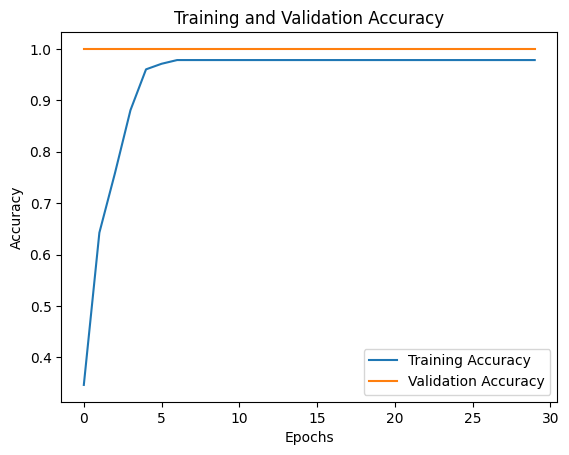

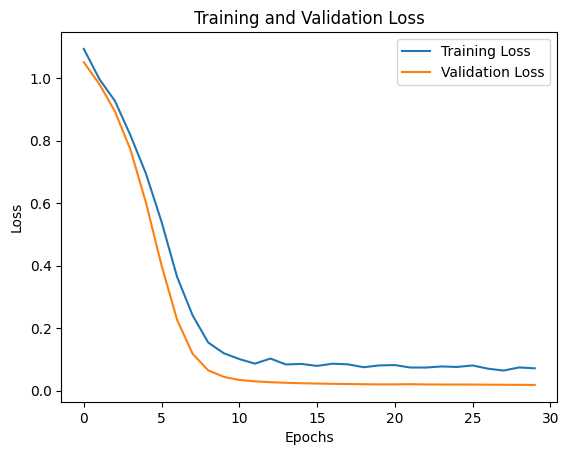

In [183]:
# Plot akurasi selama pelatihan dan validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss selama pelatihan dan validasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
